In [1]:
from TSInterpret.data import load_data
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset

# Parameters

In [2]:
dataset='GunPoint'

# Load Data

In [3]:
#TODO include OneHot Encoding Options
train_x,test_x, train_y, test_y = load_data.load_basic_dataset(dataset,scaling=None,mode='feat',cwd='/media/jacqueline/Data/UCRArchive_2018/')

In [4]:
test_x.shape

(150, 1, 150)

In [5]:
print(test_y.shape)

(150,)


In [6]:
#enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
enc1=pickle.load(open(f'../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [7]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../ClassificationModels/models/{dataset}/ResNet'))
model.eval()
#fit(model,train_loader,test_loader)
#if dataset in os.listdir('./ClassificationModels/models/'):
#    print('Folder exists')
#else: 
#    os.mkdir(f'./ClassificationModels/models/{dataset}')
#torch.save(model.state_dict(), f'./ClassificationModels/models/{dataset}/ResNet')

#test_preds, ground_truth = get_all_preds(model, test_loader)
#ground_truth=np.argmax(ground_truth,axis=1)

#sns.set(rc={'figure.figsize':(5,4)})
#heatmap=confusion_matrix(ground_truth, test_preds)
#sns.heatmap(heatmap, annot=True)
#plt.savefig(f'./ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
#plt.close()
#acc= accuracy_score(ground_truth, test_preds)
#a = classification_report(ground_truth, test_preds, output_dict=True)
#dataframe = pd.DataFrame.from_dict(a)
#dataframe.to_csv(f'./ClassificationModels/models/{dataset}/classification_report.csv', index = False)

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

# Explanation Algo

In [8]:
explained_instance = train_x[0]
nb_interpretable_feature = 10
explanation_size = 5
nb_neighbors = 1000
learning_process_name = 'Lime'
transform_name = 'straight_line'
model_to_explain=model

In [9]:
from TSInterpret.InterpretabilityModels.leftist.leftist import LEFTIST

2022-06-14 16:33:51.305630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 16:33:51.305650: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
leftist = LEFTIST(model_to_explain,(test_x,None),mode='feat', backend='PYT')

In [11]:
explanations = leftist.explain(np.array(explained_instance),1000,explanation_size=explanation_size,learning_process_name='Lime',transform_name='random')
#,transform_name='mean'

Change From Torch True
Shape before predict torch.Size([1000, 1, 150])


/media/jacqueline/Data/TSInterpret/TSInterpret/Models/PyTorchModel.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = torch.nn.functional.softmax(out).detach().numpy()


feat
NOT Time mode
0


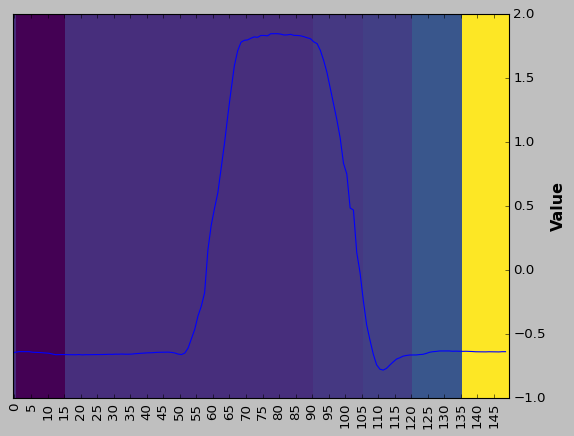

In [12]:
leftist.plot(np.array([explained_instance]),np.array([explanations[1]]))